<a href="https://colab.research.google.com/github/Shyumchandra/Advanced_Python/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# === Load and Preprocess Data ===
df = pd.read_csv("/content/synthetic_cybersecurity_data.csv")
df['Protocol'] = df['Protocol'].map({"TCP": 0, "UDP": 1, "ICMP": 2})

X = df.drop(columns=['Attack_Label'])
y = df['Attack_Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Data Preprocessing Done!")

✅ Data Preprocessing Done!


In [ ]:
# === Bias-Boosted ELM (BBELM) ===
class BiasBoostedELM:
    def __init__(self, n_hidden=500):
        self.n_hidden = n_hidden

    def fit(self, X, y):
        self.input_weights = np.random.uniform(-1, 1, (X.shape[1], self.n_hidden))
        self.biases = np.random.uniform(-1, 1, (self.n_hidden,))
        H = np.tanh(np.dot(X, self.input_weights) + self.biases)
        self.beta = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = np.tanh(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.beta)

In [ ]:
elm_model = BiasBoostedELM(n_hidden=1000)
elm_model.fit(X_train, y_train)
y_pred_elm = np.round(elm_model.predict(X_test))
elm_acc = accuracy_score(y_test, y_pred_elm)
print(f"✅ BBELM Accuracy: {elm_acc * 100:.2f}%")

✅ BBELM Accuracy: 96.70%


In [ ]:
# === MLP Model ===
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)
print(f"✅ MLP Accuracy: {mlp_acc * 100:.2f}%")

✅ MLP Accuracy: 99.10%


In [ ]:
# === Soft Outputs ===
bbelm_train_outputs = elm_model.predict(X_train).reshape(-1, 1)
bbelm_test_outputs = elm_model.predict(X_test).reshape(-1, 1)

mlp_train_outputs = mlp_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
mlp_test_outputs = mlp_model.predict_proba(X_test)[:, 1].reshape(-1, 1)


In [ ]:
# === Feature Fusion (Weighted + Nonlinear Interaction) ===
alpha, beta = 0.6, 0.4
fused_train = alpha * bbelm_train_outputs + beta * mlp_train_outputs
fused_test = alpha * bbelm_test_outputs + beta * mlp_test_outputs

interaction_train = bbelm_train_outputs * mlp_train_outputs
interaction_test = bbelm_test_outputs * mlp_test_outputs

X_train_bel = np.hstack([X_train, fused_train, interaction_train])
X_test_bel = np.hstack([X_test, fused_test, interaction_test])

In [ ]:
# === BEL Model ===
class BrainEmotionalLearning:
    def __init__(self, lr=0.03, epochs=300):
        self.lr = lr
        self.epochs = epochs
        self.amygdala_weight = None
        self.orbitofrontal_weight = None

    def fit(self, X, y):
        self.amygdala_weight = np.random.rand(X.shape[1])
        self.orbitofrontal_weight = np.random.rand(X.shape[1])
        for _ in range(self.epochs):
            net_output = self._net_output(X)
            error = y - net_output
            delta = self.lr * np.dot(error, X) / X.shape[0]
            self.amygdala_weight += delta
            self.orbitofrontal_weight -= delta

    def _net_output(self, X):
        a_out = np.dot(X, self.amygdala_weight)
        o_out = np.dot(X, self.orbitofrontal_weight)
        return np.tanh(a_out - o_out)

    def predict(self, X):
        return np.round(self._net_output(X))

    def predict_proba(self, X):
        return self._net_output(X)

    def online_update(self, X, y):
        """
        Online update of weights using one sample.
        """
        net_output = self._net_output(X)
        error = y - net_output
        delta = self.lr * error * X.flatten()
        self.amygdala_weight += delta
        self.orbitofrontal_weight -= delta
        print(f"[Online Update] Amygdala weights: {self.amygdala_weight}")
        print(f"[Online Update] Orbitofrontal weights: {self.orbitofrontal_weight}")

bel_model = BrainEmotionalLearning(lr=0.03, epochs=300)
bel_model.fit(X_train_bel, y_train)

# BEL Accuracy
y_pred_bel = bel_model.predict(X_test_bel)
bel_acc = accuracy_score(y_test, y_pred_bel)
print(f"✅ BEL Model Accuracy: {bel_acc * 100:.2f}%")

print("\n=== BEL Classification Report ===")
print(classification_report(y_test, y_pred_bel))




✅ BEL Model Accuracy: 99.00%

=== BEL Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       591
           1       0.99      0.99      0.99       409

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



🎯 Final Ensemble Accuracy (BEL + MLP): 99.10%


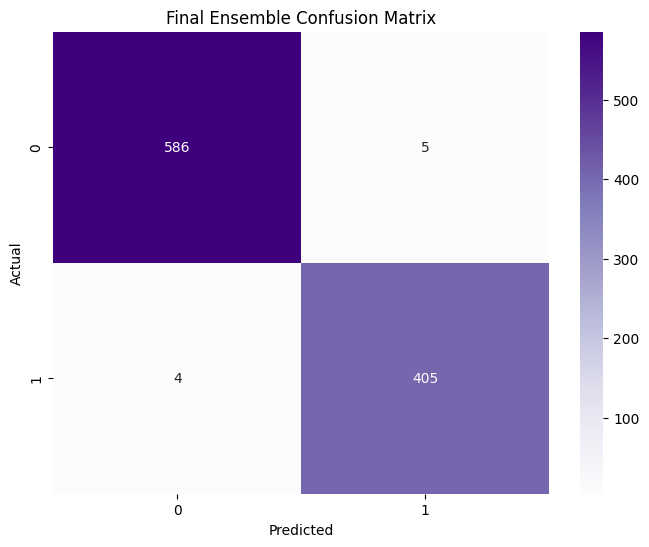

In [ ]:
# === Final Ensemble (BEL + MLP) ===
bel_probs = bel_model.predict_proba(X_test_bel)
mlp_probs = mlp_test_outputs.flatten()

final_probs = 0.5 * bel_probs + 0.5 * mlp_probs
y_pred_final = np.round(np.tanh(final_probs))
final_acc = accuracy_score(y_test, y_pred_final)
print(f"🎯 Final Ensemble Accuracy (BEL + MLP): {final_acc * 100:.2f}%")

# === Confusion Matrix ===
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Ensemble Confusion Matrix")
plt.show()

/tmp/ipython-input-12-2005228922.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


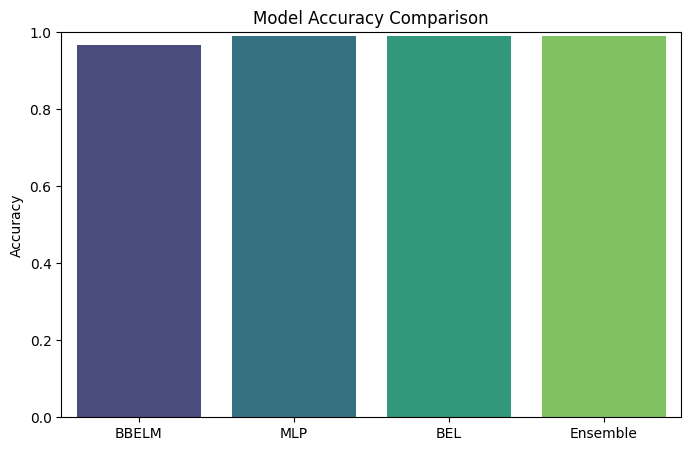

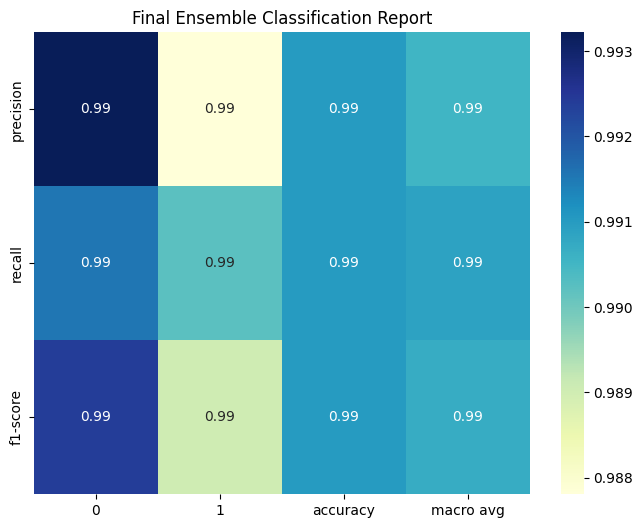

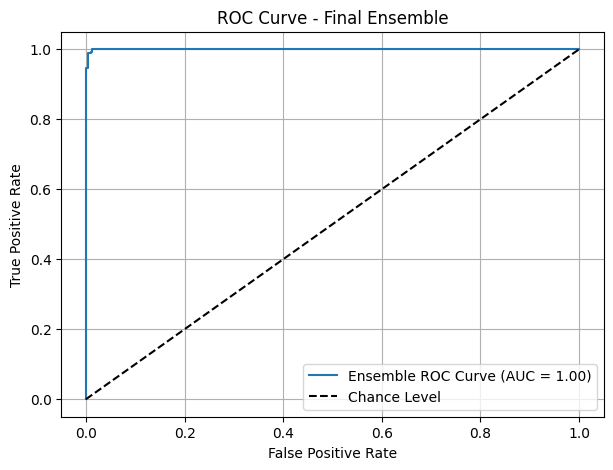

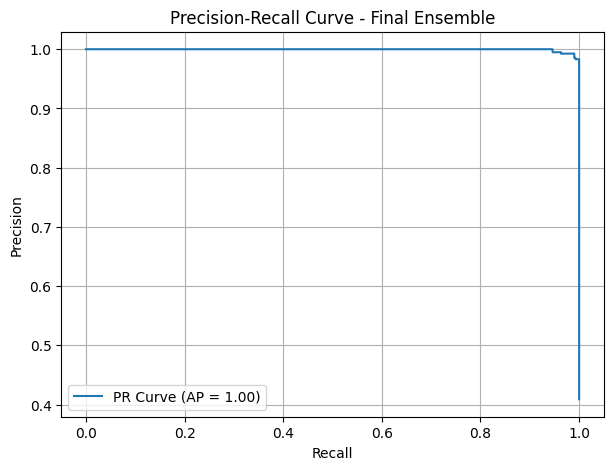

/tmp/ipython-input-12-2005228922.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, palette="coolwarm")


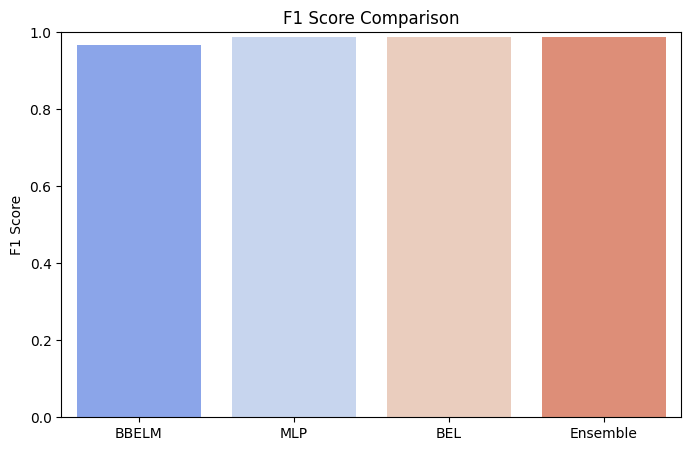

In [ ]:
# === Accuracy Comparison ===
plt.figure(figsize=(8, 5))
models = ["BBELM", "MLP", "BEL", "Ensemble"]
accuracies = [elm_acc, mlp_acc, bel_acc, final_acc]
sns.barplot(x=models, y=accuracies, palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()
print()

# === Classification Report Heatmap ===
report = classification_report(y_test, y_pred_final, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :-1]  # Remove 'accuracy' and avg rows
plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Final Ensemble Classification Report")
plt.show()
print()

# === ROC Curve ===
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, final_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Ensemble ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Ensemble')
plt.legend()
plt.grid(True)
plt.show()
print()

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, final_probs)
ap_score = average_precision_score(y_test, final_probs)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Final Ensemble")
plt.legend()
plt.grid(True)
plt.show()
print()

from sklearn.metrics import f1_score

f1_scores = [
    f1_score(y_test, y_pred_elm, average='weighted'),
    f1_score(y_test, y_pred_mlp),
    f1_score(y_test, y_pred_bel),
    f1_score(y_test, y_pred_final)
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=f1_scores, palette="coolwarm")
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()



In [ ]:
!pip install pyngrok
from pyngrok import ngrok
!ngrok authtoken 2uaCjRKzKxDEaqukwy5kxWK9k6C_43C8X7WEGyz2mZrj2n4pE

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import joblib
# Save BBELM
joblib.dump(elm_model, "bbelm_model.pkl")

# Save MLP (teacher model)
joblib.dump(mlp_model, "mlp_model.pkl")


# Save the scaler used for input normalization
joblib.dump(scaler, "scaler.pkl")



print("✅ All models and scaler saved successfully!")


✅ All models and scaler saved successfully!


In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok
import threading
import time
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Load everything needed ===
# These should be pre-trained and saved using joblib or in memory
bbelm_model = joblib.load("bbelm_model.pkl")     # Trained BBELM
mlp_model = joblib.load("mlp_model.pkl")         # Trained MLP
bel_model = joblib.load("bel_model.pkl")         # Trained BEL
scaler = joblib.load("scaler.pkl")               # Scaler used for preprocessing

# Protocol mapping
protocol_mapping = {"TCP": 0, "UDP": 1, "ICMP": 2}

# API Key for security
API_KEY = "secure_api_key_123"

# Flask setup
app = Flask(__name__)

# Ngrok Tunnel
public_url = ngrok.connect(5000)
print(f"🚀 BEL API running at: {public_url}")

def autosave_bel_model(interval=300):
    """
    Save the BEL model every `interval` seconds (default 5 minutes).
    """
    while True:
        time.sleep(interval)
        joblib.dump(bel_model, "bel_model_updated.pkl")
        print("[AutoSave] BEL model saved.")


@app.route("/predict", methods=["POST"])
def predict():
    try:
        # === Security check ===
        api_key = request.headers.get("X-API-KEY")
        if api_key != API_KEY:
            return jsonify({"error": "Unauthorized access"}), 401

        # === Data preparation ===
        data = request.get_json()
        if not data:
            return jsonify({"error": "No data provided"}), 400

        input_df = pd.DataFrame([data])
        input_df["Protocol"] = input_df["Protocol"].map(protocol_mapping)

        # Optional ground truth (for online learning)
        true_label = data.get("label")  # 0 or 1

        # === Normalize input ===
        input_scaled = scaler.transform(input_df)

        # === Get BBELM and MLP soft outputs ===
        bbelm_soft = bbelm_model.predict(input_scaled).reshape(1, 1)
        mlp_soft = mlp_model.predict_proba(input_scaled)[:, 1].reshape(1, 1)

        # === Prepare BEL input ===
        bel_input = np.hstack([input_scaled, bbelm_soft, mlp_soft])

        # === Predict with BEL ===
        bel_pred = bel_model.predict(bel_input)[0]
        prediction_label = "attack" if bel_pred >= 0.5 else "normal"

        # === Perform online update if true label is provided ===
        if true_label is not None:
            bel_model.online_update(bel_input, np.array([true_label]))

        return jsonify({"prediction": prediction_label})

    except Exception as e:
        return jsonify({"error": str(e)}), 100

if __name__ == "__main__":
    autosave_thread = threading.Thread(target=autosave_bel_model, args=(300,), daemon=True)
    autosave_thread.start()
    app.run(port=5000)


🚀 BEL API running at: NgrokTunnel: "https://802b-34-106-255-144.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:16:21] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:16:21] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:16:42] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:17:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:17:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:17:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:17:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:17:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:17:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2025 05:17:11] "POST /predict HTTP/

[AutoSave] BEL model saved.
[AutoSave] BEL model saved.
